In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [2]:
def load_images(folder_path, image_size=(64,64)):
    data = []
    labels = []

    label = os.path.basename(folder_path)

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path): 
            img = cv2.imread(img_path)
            if img is not None: 
                img = cv2.resize(img, image_size) 
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\Kidneys Images"

data_cyst, labels_cyst = load_images(os.path.join(dataset_path, 'cyst'))
data_normal, labels_normal = load_images(os.path.join(dataset_path, 'normal'))
data_stone, labels_stone = load_images(os.path.join(dataset_path, 'stone'))
data_tumor, labels_tumor = load_images(os.path.join(dataset_path, 'tumor'))

In [3]:
All_data = np.concatenate([data_cyst, data_normal, data_stone,data_tumor])
All_labels = np.concatenate([labels_cyst, labels_normal, labels_stone, labels_tumor])

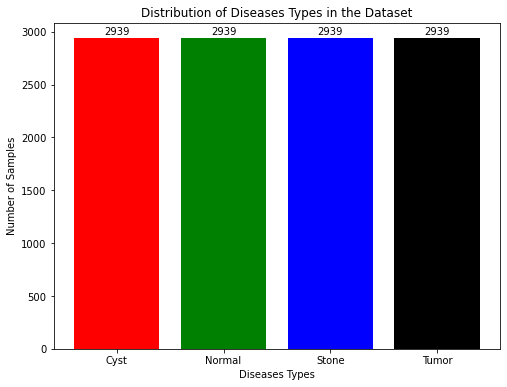

In [4]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue', 'black'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['Cyst', 'Normal', 'Stone', 'Tumor' ])
plt.show()

In [5]:
All_data_normalized = All_data / 255.0

In [6]:
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [7]:
image_size = (64, 64)
num_classes = 4

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [9]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)

x = Reshape((1, -1))(x)

lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.3)(lstm_out)  

attention_output = Attention()(lstm_out)
combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

outputs = Dense(num_classes, activation="softmax")(combined_output)

combined_model = Model(inputs=inputs, outputs=outputs)

combined_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 16)           448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 31, 31, 16)           0         ['max_pooling2d[0][0]']   

In [10]:
# Train the model with callbacks
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
531/531 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7344

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


531/531 [==============================] - 25s 42ms/step - loss: 0.6189 - accuracy: 0.7344 - val_loss: 0.2786 - val_accuracy: 0.8712
Epoch 2/20
531/531 [==============================] - 21s 39ms/step - loss: 0.2393 - accuracy: 0.9025 - val_loss: 0.2305 - val_accuracy: 0.8973
Epoch 3/20
531/531 [==============================] - 21s 40ms/step - loss: 0.1600 - accuracy: 0.9316 - val_loss: 0.1518 - val_accuracy: 0.9360
Epoch 4/20
531/531 [==============================] - 21s 39ms/step - loss: 0.1177 - accuracy: 0.9500 - val_loss: 0.1167 - val_accuracy: 0.9526
Epoch 5/20
531/531 [==============================] - 21s 40ms/step - loss: 0.0899 - accuracy: 0.9646 - val_loss: 0.1046 - val_accuracy: 0.9580
Epoch 6/20
531/531 [==============================] - 22s 41ms/step - loss: 0.0823 - accuracy: 0.9666 - val_loss: 0.1228 - val_accuracy: 0.9500
Epoch 7/20
531/531 [==============================] - 22s 41ms/step - loss: 0.0671 - accuracy: 0.9749 - val_loss: 0.1159 - val_accuracy: 0.9540
Epo

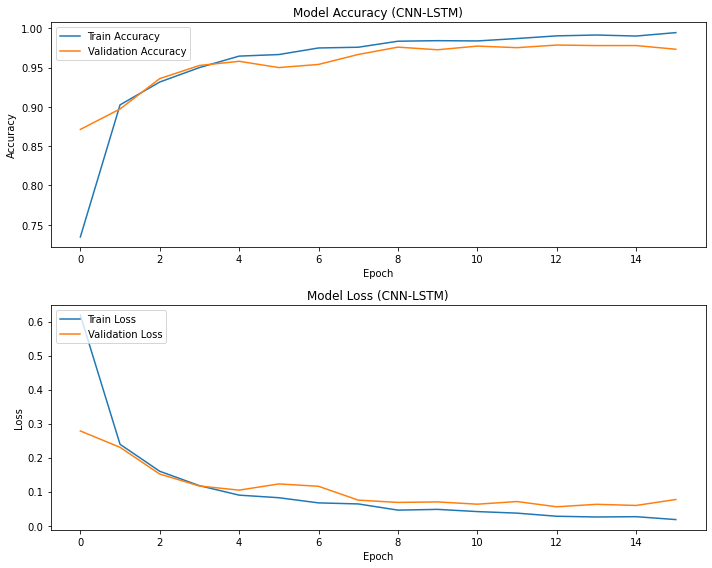

In [11]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model on the test set
test_predictions1 = combined_model.predict(test_data)
test_predictions_classes1 = np.argmax(test_predictions1, axis=1)
CNN_LSTM_class_report1 = classification_report(test_labels, test_predictions_classes1, target_names=label_encoder.classes_)
print("Classification Report:\n", CNN_LSTM_class_report1)

56/56 [==============================] - 1s 11ms/step
Classification Report:
               precision    recall  f1-score   support

        cyst       1.00      1.00      1.00       434
      normal       0.98      0.96      0.97       449
       stone       0.96      0.98      0.97       432
       tumor       1.00      0.99      1.00       449

    accuracy                           0.98      1764
   macro avg       0.98      0.98      0.98      1764
weighted avg       0.98      0.98      0.98      1764



In [13]:
accuracy = accuracy_score(test_labels, test_predictions_classes1)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 98.36%


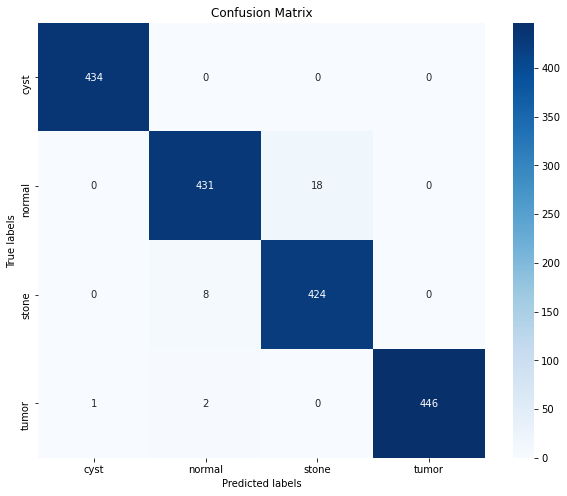

In [14]:
conf_matrix = confusion_matrix(test_labels, test_predictions_classes1)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
#combined_model.save("trained_combined_model_Attention.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
